In [1]:
%config IPCompleter.greedy=True
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
import pandas as pd, numpy as np, os, sys, re, pickle, math, copy
import matplotlib.pyplot as plt
from IPython.display import display, HTML
from sklearn.pipeline import Pipeline

import util

Raw data fields: ['DESCR', 'data', 'feature_names', 'target']

Labels:
[4.526 3.585 3.521 3.413] (20640,)


,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude
0,8.3252,41.0,6.984127,1.023810,322.0,2.555556,37.88,-122.23
1,8.3014,21.0,6.238137,0.971880,2401.0,2.109842,37.86,-122.22
2,7.2574,52.0,8.288136,1.073446,496.0,2.802260,37.85,-122.24
3,5.6431,52.0,5.817352,1.073059,558.0,2.547945,37.85,-122.25


MedInc        float64
HouseAge      float64
AveRooms      float64
AveBedrms     float64
Population    float64
AveOccup      float64
Latitude      float64
Longitude     float64
dtype: object

(20640, 8)

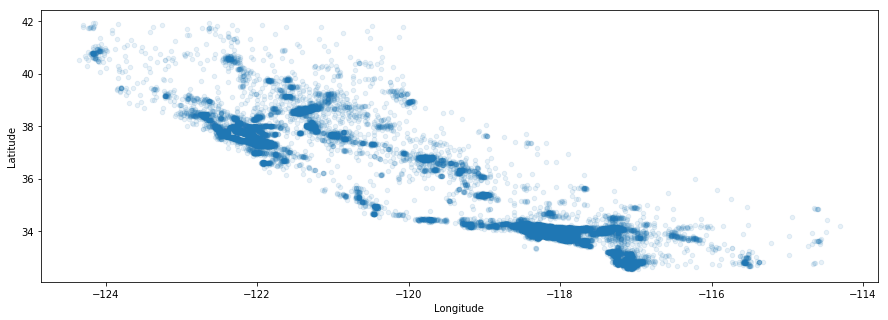

In [3]:
from sklearn.datasets import fetch_california_housing

housing = fetch_california_housing()
print("Raw data fields:", dir(housing))

labels = housing.target
print('\nLabels:')
print(labels[0:4], labels.shape)

data = pd.DataFrame(housing.data, columns = housing.feature_names)
util.showDF(data)
data.plot(kind='scatter', x='Longitude', y='Latitude', figsize=(15, 5), alpha=0.1)

In [4]:
pipeline = Pipeline([
    ('boxcox', util.BoxCoxTransformer()),
    ('std_scaler', util.StandardScaler())
])
modelData = pipeline.fit_transform(data.values)
features = data.columns

lmbdas = pipeline.steps[0][1].lmbdas
util.showDF(pd.DataFrame(modelData, columns=features))
print('Data lambdas:', lmbdas)

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude
0,1.973032,0.973907,1.050289,-0.274508,-1.611478,-0.350862,1.044085,-1.325659
1,1.965637,-0.562614,0.654056,-0.617175,1.089104,-1.092135,1.037835,-1.320779
2,1.625091,1.749833,1.649967,0.030290,-1.135984,-0.011196,1.034705,-1.330538
3,1.020234,1.749833,0.408488,0.027992,-0.997570,-0.362015,1.034705,-1.335417


MedInc        float64
HouseAge      float64
AveRooms      float64
AveBedrms     float64
Population    float64
AveOccup      float64
Latitude      float64
Longitude     float64
dtype: object

(20640, 8)

Data lambdas: [array([0.32505787]), array([0.80443759]), array([0.1107953]), array([0.02414262]), array([0.24502036]), array([0.03763226]), array([0.39838321]), array([1.03290346])]


In [6]:
modelLabels = pipeline.fit_transform(labels.reshape(-1,1))
print('Model labels:', modelLabels[0:4], modelLabels.shape)
labelLambda = pipeline.steps[0][1].lmbdas[0][0]
print('Model label lambda:', labelLambda)

Model labels: [[1.74240332]
 [1.26409287]
 [1.22813115]
 [1.16626549]] (20640, 1)
Model label lambda: 0.2489848786786134


In [14]:
shuffleIndices = np.random.permutation(modelData.shape[0])
trainSize = int(modelData.shape[0] * 2/3)

x, y = modelData[shuffleIndices, :], modelLabels[shuffleIndices]
trains, tests = x[:trainSize, :], x[trainSize:, :]
trainLabels, testLabels = y[:trainSize], y[trainSize:]
print(trains.shape, tests.shape, trainLabels.shape, testLabels.shape)

(13760, 8) (6880, 8) (13760, 1) (6880, 1)


In [38]:
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor

In [41]:
linReg = LinearRegression()
linReg.fit(trains, trainLabels)
util.evaluteRegression(linReg, trains, trainLabels, tests, testLabels)

Training MSE: 0.6062140527965052
Testing MSE: 0.607652467584988
Training MSE/testing MSE: 99.76%
Likely did not overfit.


In [42]:
dtReg = DecisionTreeRegressor()
dtReg.fit(trains, trainLabels)
util.evaluteRegression(dtReg, trains, trainLabels, tests, testLabels)

Training MSE: 6.052194999699462e-06
Testing MSE: 0.5822819923349366
Training MSE/testing MSE: 0.00%
Overfitting!!!


In [46]:
from sklearn.model_selection import cross_val_score

def showScores(scores):
    print('Scores:', scores)
    print('Mean scores:', scores.mean())
    print('Score standard deviation:', scores.std())
    
scores = cross_val_score(dtReg, trains, trainLabels, scoring='neg_mean_squared_error', cv=10)
scores = np.sqrt(-scores)
showScores(scores)

scores = cross_val_score(linReg, trains, trainLabels, scoring='neg_mean_squared_error', cv=10)
scores = np.sqrt(-scores)
showScores(scores)

Scores: [0.6245675  0.58339374 0.60047398 0.61907571 0.59667143 0.57499476
 0.59386301 0.57550751 0.58361742 0.60840533]
Mean scores: 0.5960570383591819
Score standard deviation: 0.01643439102327139
Scores: [0.60071112 0.59334736 0.59944258 0.63023509 0.63823085 0.56818836
 0.6241315  0.60017698 0.63302539 0.5878033 ]
Mean scores: 0.6075292527516809
Score standard deviation: 0.021651127052865454


In [56]:
from sklearn.ensemble import RandomForestRegressor

rfReg = RandomForestRegressor()
rfReg.fit(trains, np.ravel(trainLabels))
util.evaluteRegression(rfReg, trains, np.ravel(trainLabels), tests, np.ravel(testLabels))

scores = cross_val_score(rfReg, trains, np.ravel(trainLabels), scoring='neg_mean_squared_error', cv=10)
scores = np.sqrt(-scores)
showScores(scores)

Training MSE: 0.18718415355431986
Testing MSE: 0.43935747316571616
Training MSE/testing MSE: 42.60%
Overfitting!!!
Scores: [0.45472285 0.45150207 0.43861489 0.45364838 0.4446166  0.43213821
 0.47940117 0.40729171 0.46615331 0.42836717]
Mean scores: 0.44564563762212117
Score standard deviation: 0.019347476366305284


In [52]:
from sklearn.externals import joblib

outFile = 'E:/tmp/rf_reg_model.pkl'
joblib.dump(rfReg, outFile)
myModel = joblib.load(outFile)

In [53]:
print(testLabels)

[[-0.21810996]
 [ 1.88071698]
 [ 0.20276913]
 ...
 [ 0.32584755]
 [-0.78631779]
 [ 1.95446685]]


In [54]:
print(np.ravel(testLabels))

[-0.21810996  1.88071698  0.20276913 ...  0.32584755 -0.78631779
  1.95446685]
